In [1]:
# -*- coding: utf-8 -*-
"""
Full script: multi-model, multi-layer adaptive probing with per-model output directories
---------------------------------------------------------------------------------------
Features:
1) Automatically detects different LLM hidden_states layout and infers layers_to_probe;
2) Run multiple models in one go (HP.MODEL_NAMES list);
3) Each model writes logs, plots, and summary JSON to outputs/<model_short>/<timestamp>/;
4) Probing is performed ONLY on samples that the model answers correctly via direct generation;
   supports repeated runs and reports 95% confidence intervals (CI).
5) All tunables (hyperparameters) are centralized in the HyperParams dataclass at the top.

        
"""
"""
model :
NousResearch/Meta-Llama-3-8B-Instruct
nvidia/AceMath-7B-Instruct
mistralai/Mistral-7B-Instruct-v0.3
Qwen/Qwen2.5-Math-7B-Instruct
"""



import os
import json
import math
import pathlib
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm as _tqdm
import logging
import time
import re
import scipy.stats as st  # for confidence intervals
from collections import Counter
import warnings
from functools import partial as _partial
from dataclasses import dataclass, asdict

# ================================
# --- Hyper-Parameters (central) ---
# ================================
@dataclass
class HyperParams:
    # -- Model list --
    MODEL_NAMES: list | None = None

    # -- Experiment control --
    N_REPETITIONS: int = 5
    BASE_SEED: int = 42

    # -- Probe training --
    PROBE_TYPE: str = "linear"          # "linear" | "mlp"
    PROBE_MLP_HIDDEN_DIM: int = 4096
    N_PROBE_EPOCHS: int = 20
    PROBE_LR: float = 1e-3
    PROBE_BATCH_SIZE: int = 64
    TEST_SPLIT_RATIO: float = 0.2

    # -- Direct generation (filtering) --
    GENERATION_BATCH_SIZE: int = 500
    GEN_MAX_NEW_TOKENS: int = 3
    GEN_DO_SAMPLE: bool = False

    # -- Tokenizer params --
    TOK_MAX_LENGTH: int = 60            # encoding/truncation length (generation & extraction)
    TOK_PADDING_SIDE: str = "left"

    # -- Dataset (addition) --
    SUM_RANGES_CONFIG: list | None = None
    N_SAMPLES_PER_SUM: int = 400
    MIN_SAMPLES_PER_CLASS_FOR_PROBING: int = 5
    MIN_ADDEND_VAL: int = 100           # minimal addend for (a, b)
    A_BOUND_LOW_FRAC: float = 0.25      # a chosen from [25%, 75%] of target
    A_BOUND_HIGH_FRAC: float = 0.75
    MAX_ATTEMPTS_MULTIPLIER: int = 20   # trials per target per sample

    # -- Activation extraction --
    ACTIVATIONS_BATCH_SIZE: int = 256

    # -- Logging / quiet mode --
    LOG_TO_CONSOLE: bool = False
    TQDM_DISABLED: bool = True
    SUPPRESS_WARNINGS: bool = True

    def __post_init__(self):
        if self.SUM_RANGES_CONFIG is None:
            self.SUM_RANGES_CONFIG = [
                {"label": "500-509", "start": 500, "count": 10},
                {"label": "600-609", "start": 600, "count": 10},
                {"label": "700-709", "start": 700, "count": 10},
                {"label": "800-809", "start": 800, "count": 10},
                {"label": "900-909", "start": 900, "count": 10},
            ]
        if self.MODEL_NAMES is None:
            self.MODEL_NAMES = [
                #"/root/autodl-tmp/llama",
                "/root/autodl-tmp/Mistral",
                #"/root/autodl-tmp/Qwen2.5-Math-7B",
                #"/root/autodl-tmp/AceMath",
                #"/root/autodl-tmp/Qwen2.5-7B-Instruct"
            ]

HP = HyperParams()

# ================================
# ---- Quiet / noise reduction ----
# ================================
os.environ.setdefault("TOKENIZERS_PARALLELISM", "false")
if HP.TQDM_DISABLED:
    os.environ["TQDM_DISABLE"] = "1"  # disable all tqdm progress bars

# Wrap tqdm to default disable=True for double insurance
tqdm = _partial(_tqdm, disable=True) if HP.TQDM_DISABLED else _tqdm

# Reduce third-party logging noise
try:
    from transformers.utils.logging import set_verbosity_error
    set_verbosity_error()  # keep only errors from transformers
except Exception:
    pass
logging.getLogger("transformers").setLevel(logging.ERROR)
logging.getLogger("torch").setLevel(logging.ERROR)
logging.getLogger("urllib3").setLevel(logging.ERROR)

# Suppress common warnings (keep critical ones)
if HP.SUPPRESS_WARNINGS:
    warnings.filterwarnings("ignore", category=UserWarning)
    warnings.filterwarnings("ignore", category=FutureWarning)

# ================================
# --- Setup logging (warm-up) ---
# ================================
os.makedirs("logs", exist_ok=True)
log_filename = f"logs/probe_gen_filtered_repeated_experiment_{time.strftime('%Y%m%d_%H%M%S')}.log"

logger = logging.getLogger("ProbeGenFilteredRepeatedExperiment")
logger.setLevel(logging.INFO)
for h in list(logger.handlers):
    logger.removeHandler(h)
fh = logging.FileHandler(log_filename, encoding='utf-8')
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s',
                              datefmt='%Y-%m-%d %H:%M:%S')
fh.setFormatter(formatter)
logger.addHandler(fh)
if HP.LOG_TO_CONSOLE:
    ch = logging.StreamHandler()
    ch.setLevel(logging.WARNING)
    ch.setFormatter(formatter)
    logger.addHandler(ch)
logger.propagate = False






In [2]:
# ================================
# --- Seeding ---
# ================================
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
    logger.info(f"Seed set to {seed_value}")

# ================================
# --- Experiment description ---
# ================================
experiment_description = """
**High-Level Logic (with Repetitions & Confidence Intervals)**
This version adds a repetition mechanism: the experiment runs multiple times (each with a different random seed),
collects probe accuracy and related metrics, and then computes the mean and confidence intervals (e.g., 95% CI).
The final figure visualizes the CI as a shaded region around the mean accuracy curve.
Probing is performed ONLY on samples that the model answers correctly via direct generation.
This helps evaluate the stability and statistical significance of the results.
"""

logger.info("Starting multi-model experiment with direct generation filtering, repetitions, and confidence intervals...")
logger.info(f"HyperParams: {json.dumps(asdict(HP), ensure_ascii=False)}")
logger.info("==================================================")
for line in experiment_description.split('\n'):
    if line.strip():
        logger.info(line)
logger.info("NOTE: Probing will be performed ONLY on samples the model answers correctly via direct generation.")
logger.info("==================================================")

In [3]:
# ================================
# --- Utilities: paths/layers/JSON ---
# ================================
def normalize_generate_to_text_list(gen_out, tokenizer):
    """
    Normalize different generate(...) return types into List[str].
    Supports:
      - torch.Tensor (batch, seq)
      - List[torch.Tensor]
      - Dict with 'sequences' or 'text'
      - List[str]
    """
    import torch
    if isinstance(gen_out, torch.Tensor):
        return tokenizer.batch_decode(gen_out, skip_special_tokens=True)
    if isinstance(gen_out, (list, tuple)):
        if len(gen_out) == 0:
            return []
        if isinstance(gen_out[0], torch.Tensor):
            return [tokenizer.decode(t.cpu().tolist(), skip_special_tokens=True) for t in gen_out]
        if isinstance(gen_out[0], str):
            return list(gen_out)
    if isinstance(gen_out, dict):
        if "sequences" in gen_out:
            seqs = gen_out["sequences"]
            if isinstance(seqs, torch.Tensor):
                return tokenizer.batch_decode(seqs, skip_special_tokens=True)
            if isinstance(seqs, (list, tuple)):
                return normalize_generate_to_text_list(seqs, tokenizer)
        if "text" in gen_out:
            txt = gen_out["text"]
            return txt if isinstance(txt, list) else [txt]
    raise TypeError(f"Unsupported generate output type for decoding: {type(gen_out)}")

def sanitize_model_id(model_id: str) -> str:
    base = os.path.basename(model_id.rstrip("/"))
    if not base:
        base = model_id.split("/")[-1]
    return re.sub(r"[^A-Za-z0-9._-]+", "_", base)

def make_output_dirs(model_id: str):
    """
    Create outputs/<model_short>/<YYYYmmdd_HHMMSS>/.
    Returns (run_dir, logs_dir, model_short, timestamp)
    """
    stamp = time.strftime("%Y%m%d_%H%M%S")
    model_short = sanitize_model_id(model_id)
    run_dir = os.path.join("outputs", model_short, stamp)
    logs_dir = os.path.join(run_dir, "logs")
    os.makedirs(logs_dir, exist_ok=True)
    return run_dir, logs_dir, model_short, stamp

@torch.no_grad()
def infer_layers_to_probe(
    model,
    tokenizer,
    device,
    *,
    probe_prompt: str = "1+1=",
    tok_max_length: int = 16
):
    """
    Detect hidden_states layout via a tiny forward pass; both the probe prompt and length are tunable.
    """
    dummy = tokenizer(probe_prompt, return_tensors="pt", padding=True, truncation=True, max_length=tok_max_length).to(device)
    out = model(**dummy)
    hs = out.hidden_states
    if hs is None:
        raise RuntimeError("hidden_states not returned; please ensure output_hidden_states=True in the forward pass.")
    hs_len = len(hs)
    cfg_layers = getattr(model.config, "num_hidden_layers", None)
    if cfg_layers is None:
        cfg_layers = getattr(model.config, "n_layer", None)
    if cfg_layers is not None:
        if hs_len == cfg_layers + 1:
            return list(range(1, cfg_layers + 1)), cfg_layers, hs_len
        elif hs_len == cfg_layers:
            return list(range(0, cfg_layers)), cfg_layers, hs_len
        else:
            if hs_len > 1:
                return list(range(1, hs_len)), hs_len - 1, hs_len
            else:
                return [0], 1, hs_len
    else:
        if hs_len > 1:
            return list(range(1, hs_len)), hs_len - 1, hs_len
        else:
            return [0], 1, hs_len

def sanitize_for_json(obj):
    """
    Recursively convert numpy types and NaNs to JSON-friendly native types.
    - np.ndarray -> list
    - np.number -> float/int
    - float('nan') -> None
    """
    if isinstance(obj, dict):
        return {k: sanitize_for_json(v) for k, v in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [sanitize_for_json(x) for x in obj]
    elif isinstance(obj, np.ndarray):
        return sanitize_for_json(obj.tolist())
    elif isinstance(obj, (np.floating,)):
        val = float(obj)
        return None if math.isnan(val) else val
    elif isinstance(obj, (np.integer,)):
        return int(obj)
    elif isinstance(obj, float):
        return None if math.isnan(obj) else obj
    else:
        return obj

# ================================
# --- Helper functions ---
# ================================
def parse_model_answer(raw_output_text, prompt_text):
    """
    Robust parsing logic:
    1) If output starts with the prompt: take the *first* number after the prompt.
    2) Else: search '= <num>' anywhere and take that number.
    3) Else: search keywords like 'is/answer/result' and take the number after them.
    4) Fallback: take the first number in the whole output.
    """
    text = raw_output_text.strip()
    if text.startswith(prompt_text):
        answer_part = text[len(prompt_text):].strip()
        m = re.match(r'^\s*(-?\d+(?:\.\d+)?)', answer_part)
        if m:
            try:
                return int(float(m.group(1)))
            except ValueError:
                pass
    m = re.search(r'=\s*(-?\d+(?:\.\d+)?)', text)
    if m:
        try:
            return int(float(m.group(1)))
        except ValueError:
            pass
    m = re.search(r'\b(?:is|answer|ans|result)\s*[:：]?\s*(-?\d+(?:\.\d+)?)', text, flags=re.IGNORECASE)
    if m:
        try:
            return int(float(m.group(1)))
        except ValueError:
            pass
    m = re.search(r'-?\d+(?:\.\d+)?', text)
    if m:
        try:
            return int(float(m.group(0)))
        except ValueError:
            pass
    return None
from contextlib import contextmanager

@contextmanager
def temp_config(model, **kwargs):
    old = {}
    for k, v in kwargs.items():
        old[k] = getattr(model.config, k, None)
        setattr(model.config, k, v)
    try:
        yield
    finally:
        for k, v in old.items():
            if v is None and hasattr(model.config, k):
                delattr(model.config, k)
            else:
                setattr(model.config, k, v)



def get_sequences_from_generate(generated):
    # 1) 直接是 Tensor
    if isinstance(generated, torch.Tensor):
        return generated
    # 2) 有 .sequences 属性（GenerationOutput 等）
    if hasattr(generated, "sequences"):
        return generated.sequences
    # 3) 字典里有 'sequences'
    if isinstance(generated, dict) and "sequences" in generated:
        return generated["sequences"]
    raise TypeError(f"Unexpected generate(...) return type: {type(generated)}")


def evaluate_model_direct_answers(
    samples_list, model, tokenizer, device,
    *, batch_size=500, max_new_tokens=6, do_sample=False, tok_max_length=60
):
    logger.info(f"Evaluating model's direct answers for {len(samples_list)} samples...")
    prompts = [s['prompt'] for s in samples_list]
    model.eval()
    generation_correct_count = 0

    gen_config = GenerationConfig(
        max_new_tokens=max_new_tokens,  # 数值题足够小
        do_sample=do_sample,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id,
        return_dict_in_generate=False,  # 降低开销
        use_cache=True
    )

    for i in tqdm(range(0, len(prompts), batch_size), desc="Model Direct Generation", unit="batch", leave=False):
        batch_prompts_text = prompts[i:i+batch_size]
        current_batch_samples = samples_list[i:i+batch_size]

        enc = tokenizer(batch_prompts_text, return_tensors="pt", padding=True, truncation=True, max_length=tok_max_length)
        # 非阻塞搬运（需要 GPU）
        inputs = {k: v.to(device, non_blocking=True) for k, v in enc.items()}

        try:
            # 生成时关闭 hidden_states 并用 inference_mode
            with torch.inference_mode(), temp_config(model, output_hidden_states=False):
                generated_ids = model.generate(
                    inputs["input_ids"], attention_mask=inputs["attention_mask"], generation_config=gen_config
                )
            sequences = get_sequences_from_generate(generated_ids)
            inp_len = inputs["input_ids"].shape[1]
            new_tokens = sequences[:, inp_len:]
            decoded_new = tokenizer.batch_decode(new_tokens, skip_special_tokens=True)
            # # 只解码新生成部分（极大减少 decode & 正则的负担）
            # inp_len = inputs["input_ids"].shape[1]
            # new_tokens = generated_ids[:, inp_len:]
            # decoded_new = tokenizer.batch_decode(new_tokens, skip_special_tokens=True)

            for j, new_txt in enumerate(decoded_new):
                sample = current_batch_samples[j]
                parsed_ans = parse_model_answer(new_txt, "")  # 这里传空 prompt，因只含新增文本
                sample['model_answer_raw'] = new_txt
                sample['model_answer_parsed'] = parsed_ans
                ok = (parsed_ans is not None and parsed_ans == sample['target_sum'])
                sample['is_correct_generation'] = ok
                generation_correct_count += int(ok)

        except Exception as e:
            logger.error(f"Error during generation/parsing for batch starting at {i}: {e}", exc_info=True)
            for s in current_batch_samples:
                s['model_answer_raw'] = "ERROR_DURING_GENERATION"
                s['model_answer_parsed'] = None
                s['is_correct_generation'] = False

    return generation_correct_count / len(samples_list) if samples_list else 0.0


def generate_samples_for_target_sums(
    target_sums_list,
    n_samples_per_sum,
    range_label,
    *,
    min_addend_val: int = 100,
    a_bound_low_frac: float = 0.25,
    a_bound_high_frac: float = 0.75,
    max_attempts_multiplier: int = 20,
):
    """
    Generate (a, b) samples such that a + b = target_sum, with controllable bounds and attempts.
    """
    all_samples = []
    logger.info(f"Range [{range_label}]: Starting dataset generation for target sums: {target_sums_list}")
    for i, target_sum in enumerate(target_sums_list):
        class_label = i
        count = 0
        attempts = 0
        max_attempts_per_sample = max_attempts_multiplier * n_samples_per_sum
        while count < n_samples_per_sum and attempts < max_attempts_per_sample:
            attempts += 1
            lower_bound_a = max(min_addend_val, int(target_sum * a_bound_low_frac))
            upper_bound_a = min(target_sum - min_addend_val, int(target_sum * a_bound_high_frac))
            if lower_bound_a >= upper_bound_a:
                lower_bound_a = min_addend_val
                upper_bound_a = target_sum - min_addend_val
            if lower_bound_a >= upper_bound_a or lower_bound_a < 1 or upper_bound_a < 1:
                if target_sum > 1:
                    a = random.randint(1, max(1, target_sum - 1))
                else:
                    continue
            else:
                a = random.randint(lower_bound_a, upper_bound_a)
            b = target_sum - a
            if b < min_addend_val and target_sum > min_addend_val * 2:
                continue
            if b < 1:
                continue
            all_samples.append({
                "prompt": f"Calculate: {a}+{b} = ",
                "target_sum": target_sum,
                "label": class_label,
                "a": a,
                "b": b
            })
            count += 1
        if count < n_samples_per_sum:
            logger.warning(f"Range [{range_label}]: Generated only {count}/{n_samples_per_sum} for target_sum {target_sum}")
    logger.info(f"Range [{range_label}]: Finished dataset generation. Total samples: {len(all_samples)}")
    return all_samples

def get_activations(
    model,
    tokenizer,
    device,
    prompts,
    layers_to_probe,
    range_label,
    *,
    batch_size: int = 16,
    tok_max_length: int = 60
):
    """
    Extract last-token hidden states for specified layers. Tunables are keyword-only.
    """
    activations = {layer: [] for layer in layers_to_probe}
    logger.info(f"Range [{range_label}]: Starting activation extraction for {len(prompts)} filtered prompts, layers {layers_to_probe}, batch size {batch_size}.")
    model.eval()
    with torch.no_grad():
        for i in tqdm(range(0, len(prompts), batch_size), desc=f"Activations for {range_label} (filtered)", unit="batch", leave=False):
            batch_prompts = prompts[i: i + batch_size]
            try:
                inputs = tokenizer(
                    batch_prompts, return_tensors="pt", padding=True, truncation=True, max_length=tok_max_length
                ).to(device)
                outputs = model(**inputs)
                hidden_states = outputs.hidden_states
                sequence_lengths = inputs.attention_mask.sum(dim=1)
                last_token_indices = sequence_lengths - 1
                for layer_idx in layers_to_probe:
                    layer_hidden_states = hidden_states[layer_idx]
                    current_batch_size_in_hs = layer_hidden_states.size(0)
                    aligned_last_token_indices = last_token_indices[:current_batch_size_in_hs]
                    valid_indices_mask = aligned_last_token_indices < layer_hidden_states.size(1)
                    actual_indices = aligned_last_token_indices[valid_indices_mask]
                    actual_layer_hs = layer_hidden_states[valid_indices_mask]
                    if actual_indices.numel() > 0:
                        last_token_activations_batch = actual_layer_hs[torch.arange(actual_layer_hs.size(0)), actual_indices, :]
                        activations[layer_idx].append(last_token_activations_batch.cpu().numpy())
                    elif current_batch_size_in_hs > 0:
                        logger.warning(f"Range [{range_label}], Batch {i//batch_size}, layer {layer_idx}: No valid last token activations extracted.")
            except Exception as e:
                logger.error(f"Range [{range_label}], Batch {i//batch_size}: Error during activation extraction: {e}", exc_info=True)
    processed_activations = {}
    for layer in layers_to_probe:
        if activations[layer]:
            try:
                processed_activations[layer] = np.concatenate(activations[layer], axis=0)
            except ValueError as e:
                logger.error(f"Range [{range_label}], Layer {layer}: Error concatenating activations: {e}.")
                processed_activations[layer] = np.array([])
        else:
            logger.warning(f"Range [{range_label}], Layer {layer}: No activations collected.")
            processed_activations[layer] = np.array([])
    logger.info(f"Range [{range_label}]: Finished activation extraction for filtered set.")
    return processed_activations

class LinearProbe(nn.Module):
    def __init__(self, in_dim: int, n_classes: int):
        super().__init__()
        self.linear = nn.Linear(in_dim, n_classes, bias=True)
    def forward(self, x):
        return self.linear(x)

class PyTorchMLPProbe(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.layer_1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.layer_2 = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        x = self.relu(self.layer_1(x))
        return self.layer_2(x)

def train_and_eval_probe(
    X_train_np,
    y_train_np,
    X_test_np,
    y_test_np,
    *,
    probe_type: str = "linear",
    mlp_hidden_dim: int = 4096,
    epochs: int = 5,
    lr: float = 1e-3,
    batch_size: int = 100,
    device=None,
    n_classes: int | None = None
):
    """
    Train & evaluate a probe (Linear/MLP). Returns (test_accuracy, classification_report_text, best_state_dict).
    """
    if device is None:
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    if n_classes is None:
        n_classes = len(np.unique(y_train_np))
    in_dim = X_train_np.shape[1]
    if probe_type == "linear":
        probe = LinearProbe(in_dim, n_classes).to(device)
    else:
        probe = PyTorchMLPProbe(in_dim, mlp_hidden_dim, n_classes).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(probe.parameters(), lr=lr)
    X_train_torch = torch.tensor(X_train_np, dtype=torch.float32)
    y_train_torch = torch.tensor(y_train_np, dtype=torch.long)
    train_dataset = torch.utils.data.TensorDataset(X_train_torch, y_train_torch)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    try:
        probe.train()
        for _ in range(epochs):
            for batch_X, batch_y in train_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                optimizer.zero_grad()
                outputs = probe(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()

        probe.eval()
        with torch.no_grad():
            X_test_torch = torch.tensor(X_test_np, dtype=torch.float32).to(device)
            pred_logits_test = probe(X_test_torch)
            y_pred_test = torch.argmax(pred_logits_test, dim=1).cpu().numpy()
            acc = accuracy_score(y_test_np, y_pred_test)
            try:
                cls_report = classification_report(
                    y_test_np, y_pred_test,
                    output_dict=False, zero_division=0
                )
            except Exception:
                cls_report = "N/A"
            return acc, cls_report, {k: v.cpu() for k, v in probe.state_dict().items()}
    except Exception as e:
        logger.error(f"Probe training/eval error: {e}", exc_info=True)
        return np.nan, "ERROR", None






In [4]:
# ================================
# --- Confidence interval calculation ---
# ================================
def calculate_mean_ci(data, confidence=0.95):
    """
    Compute mean and symmetric CI using t-distribution.
    Returns (mean, ci_lower, ci_upper).
    """
    data_array = np.array([x for x in data if not (isinstance(x, float) and math.isnan(x))])
    if len(data_array) < 2:
        mean = np.nanmean(data_array) if len(data_array) == 1 else np.nan
        return mean, mean, mean
    mean = np.mean(data_array)
    sem = st.sem(data_array)
    if np.isnan(sem) or sem == 0:
        return mean, mean, mean
    ci_margin = sem * st.t.ppf((1 + confidence) / 2., len(data_array) - 1)
    return mean, mean - ci_margin, mean + ci_margin


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

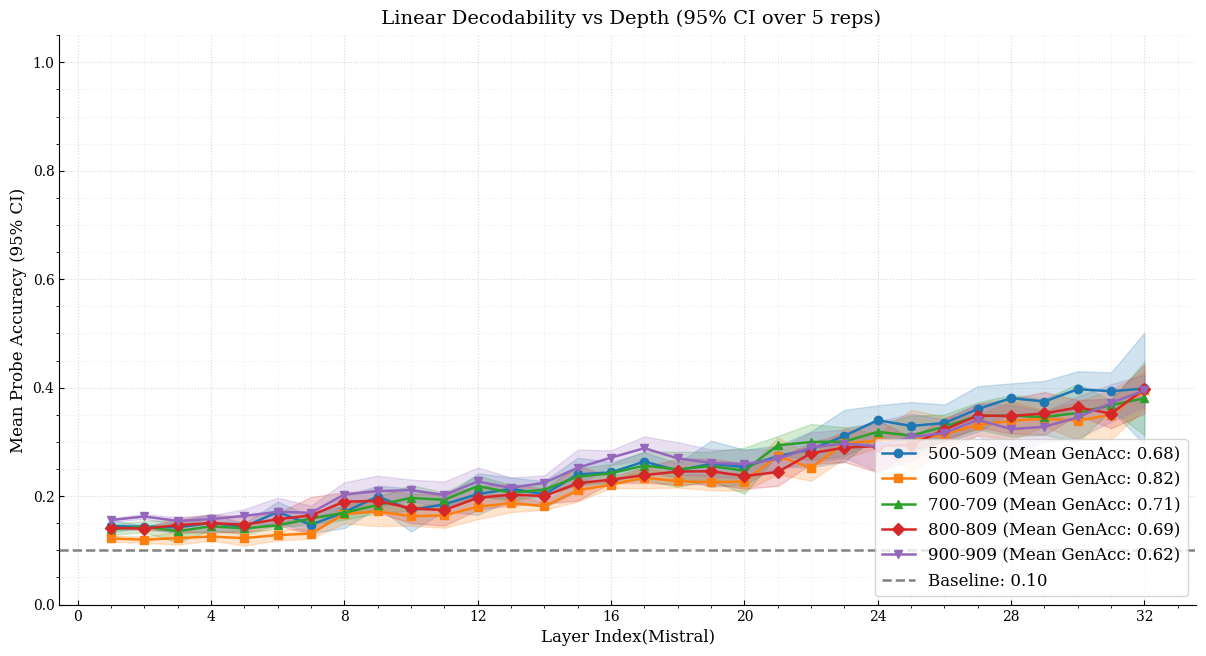

In [5]:
# =====================================================================
# --- 1. Config & model loading (multi-model; per-model outputs) ---
# =====================================================================
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
logger.info(f"Global device: {DEVICE}")
logger.info(f"Selected PROBE_TYPE: {HP.PROBE_TYPE} (mlp_hidden={HP.PROBE_MLP_HIDDEN_DIM})")

N_CLASSES_PER_RANGE = HP.SUM_RANGES_CONFIG[0]["count"]  # Assume equal class count across ranges

# Run for each model
for MODEL_NAME in HP.MODEL_NAMES:
    # -- Per-model output dirs & logging --
    run_dir, logs_dir, model_short_name, ts = make_output_dirs(MODEL_NAME)
    for h in list(logger.handlers):
        logger.removeHandler(h)
    log_path = os.path.join(logs_dir, f"experiment_{model_short_name}_{ts}.log")
    fh = logging.FileHandler(log_path, encoding='utf-8')
    fh.setLevel(logging.INFO)
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s',
                                  datefmt='%Y-%m-%d %H:%M:%S')
    fh.setFormatter(formatter)
    logger.addHandler(fh)
    if HP.LOG_TO_CONSOLE:
        ch = logging.StreamHandler()
        ch.setLevel(logging.WARNING)
        ch.setFormatter(formatter)
        logger.addHandler(ch)
    logger.propagate = False

    logger.info("=" * 70)
    logger.info(f"MODEL = {MODEL_NAME}")
    logger.info(f"Run dir = {run_dir}")
    logger.info(f"Logs at = {log_path}")
    logger.info("=" * 70)

    # -- Load model --
    try:
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)
        model = AutoModelForCausalLM.from_pretrained(
            MODEL_NAME,
            output_hidden_states=True,
            torch_dtype=torch.float16 if DEVICE.type == 'cuda' else torch.float32,
            trust_remote_code=True,
        )
        if DEVICE.type == 'cpu' and model.dtype == torch.float16:
            model = model.to(torch.float32)
        model = model.to(DEVICE)
        model.eval()
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        tokenizer.padding_side = HP.TOK_PADDING_SIDE
        logger.info("Model & tokenizer loaded.")
    except Exception as e:
        logger.error(f"Failed to load model {MODEL_NAME}: {e}", exc_info=True)
        continue  # skip this model and continue

    # -- Infer layers to probe automatically --
    try:
        layers_to_probe, logical_num_layers, hs_len = infer_layers_to_probe(
            model, tokenizer, DEVICE,
            probe_prompt="2+3=",
            tok_max_length=min(HP.TOK_MAX_LENGTH, 16)
        )
        logger.info(
            f"Layer probing indices = {layers_to_probe[:6]}... (total {len(layers_to_probe)}) | "
            f"logical_num_layers={logical_num_layers}, hidden_states_len={hs_len}"
        )
    except Exception as e:
        logger.error(f"Failed to infer layers_to_probe: {e}", exc_info=True)
        continue

    # -- Initialize aggregated result containers based on layers --
    final_aggregated_results = {
        range_cfg["label"]: {
            "target_sums": list(range(range_cfg["start"], range_cfg["start"] + range_cfg["count"])) ,
            "n_classes": range_cfg["count"],
            "generation_accuracies_reps": [],
            "original_sample_counts_reps": [],
            "filtered_sample_counts_reps": [],
            "probe_accuracies_per_layer_reps": {layer: [] for layer in layers_to_probe},
            "best_layer_indices_reps": [],
            "best_layer_accuracies_reps": [],
            "best_layer_reports_reps": []
        } for range_cfg in HP.SUM_RANGES_CONFIG
    }

    # -- Main repetition loop --
    for rep_idx in tqdm(range(HP.N_REPETITIONS), desc=f"[{model_short_name}] Repetitions", unit="rep", leave=False):
        current_seed = HP.BASE_SEED + rep_idx
        logger.info(f"========== START REP {rep_idx + 1}/{HP.N_REPETITIONS} seed={current_seed} ==========")
        set_seed(current_seed)

        for range_config_idx, range_config in enumerate(HP.SUM_RANGES_CONFIG):
            current_range_label = range_config["label"]
            current_target_sums = final_aggregated_results[current_range_label]["target_sums"]
            current_n_classes = final_aggregated_results[current_range_label]["n_classes"]

            current_min_samples_total_for_probing = max(
                current_n_classes * HP.MIN_SAMPLES_PER_CLASS_FOR_PROBING * (1/HP.TEST_SPLIT_RATIO if HP.TEST_SPLIT_RATIO > 0 else 4),
                HP.PROBE_BATCH_SIZE * 2
            )

            logger.info(f"--- Rep {rep_idx+1}, Range [{current_range_label}] ---")

            # 1) Generate data
            all_samples_data_for_range = generate_samples_for_target_sums(
                current_target_sums, HP.N_SAMPLES_PER_SUM, current_range_label,
                min_addend_val=HP.MIN_ADDEND_VAL,
                a_bound_low_frac=HP.A_BOUND_LOW_FRAC,
                a_bound_high_frac=HP.A_BOUND_HIGH_FRAC,
                max_attempts_multiplier=HP.MAX_ATTEMPTS_MULTIPLIER
            )
            original_sample_count_this_rep = len(all_samples_data_for_range)
            if not all_samples_data_for_range:
                logger.error(f"Range [{current_range_label}]: no samples; skip.")
                final_aggregated_results[current_range_label]["generation_accuracies_reps"].append(0.0)
                final_aggregated_results[current_range_label]["original_sample_counts_reps"].append(0)
                final_aggregated_results[current_range_label]["filtered_sample_counts_reps"].append(0)
                for layer in layers_to_probe:
                    final_aggregated_results[current_range_label]["probe_accuracies_per_layer_reps"][layer].append(np.nan)
                final_aggregated_results[current_range_label]["best_layer_indices_reps"].append(-1)
                final_aggregated_results[current_range_label]["best_layer_accuracies_reps"].append(np.nan)
                final_aggregated_results[current_range_label]["best_layer_reports_reps"].append("Skipped - no initial samples")
                continue

            # 1.5) Direct generation filtering
            generation_accuracy_for_range_this_rep = evaluate_model_direct_answers(
                all_samples_data_for_range, model, tokenizer, DEVICE,
                batch_size=HP.GENERATION_BATCH_SIZE,
                max_new_tokens=HP.GEN_MAX_NEW_TOKENS,
                do_sample=HP.GEN_DO_SAMPLE,
                tok_max_length=HP.TOK_MAX_LENGTH
            )
            filtered_samples_data_for_range = [s for s in all_samples_data_for_range if s.get('is_correct_generation', False)]
            filtered_sample_count_this_rep = len(filtered_samples_data_for_range)
            logger.info(f"Filter: original={original_sample_count_this_rep}, filtered={filtered_sample_count_this_rep}")

            # Record generation and counts
            final_aggregated_results[current_range_label]["generation_accuracies_reps"].append(generation_accuracy_for_range_this_rep)
            final_aggregated_results[current_range_label]["original_sample_counts_reps"].append(original_sample_count_this_rep)
            final_aggregated_results[current_range_label]["filtered_sample_counts_reps"].append(filtered_sample_count_this_rep)

            if filtered_sample_count_this_rep < current_min_samples_total_for_probing:
                logger.warning(f"Insufficient filtered samples ({filtered_sample_count_this_rep} < {current_min_samples_total_for_probing}); skip probing.")
                for layer in layers_to_probe:
                    final_aggregated_results[current_range_label]["probe_accuracies_per_layer_reps"][layer].append(np.nan)
                final_aggregated_results[current_range_label]["best_layer_indices_reps"].append(-1)
                final_aggregated_results[current_range_label]["best_layer_accuracies_reps"].append(np.nan)
                final_aggregated_results[current_range_label]["best_layer_reports_reps"].append("Skipped - insufficient filtered samples")
                continue

            all_labels_np_for_range = np.array([s['label'] for s in filtered_samples_data_for_range])
            all_prompts_for_range = [s['prompt'] for s in filtered_samples_data_for_range]

            # 2) Extract activations only for filtered data
            all_layer_activations_for_range = get_activations(
                model, tokenizer, DEVICE,
                all_prompts_for_range, layers_to_probe, current_range_label,
                batch_size=HP.ACTIVATIONS_BATCH_SIZE,
                tok_max_length=HP.TOK_MAX_LENGTH
            )

            results_per_layer_this_rep_range = {layer: np.nan for layer in layers_to_probe}
            best_layer_accuracy_this_rep_range = -1.0
            best_layer_index_this_rep_range = -1
            best_layer_report_this_rep_range = "N/A"

            # 3) Train a probe per layer
            for layer in tqdm(layers_to_probe, desc=f"Rep {rep_idx+1} Probe [{current_range_label}]", unit="layer", leave=False):
                current_X_activations = all_layer_activations_for_range.get(layer)

                if current_X_activations is None or current_X_activations.size == 0 or current_X_activations.shape[0] != len(all_labels_np_for_range):
                    logger.warning(f"Skip layer {layer}: activation mismatch.")
                    results_per_layer_this_rep_range[layer] = np.nan
                    continue

                X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
                    current_X_activations, all_labels_np_for_range,
                    test_size=HP.TEST_SPLIT_RATIO, random_state=current_seed, stratify=all_labels_np_for_range
                )

                acc_overall_test_this_layer, cls_report, _ = train_and_eval_probe(
                    X_train_np, y_train_np, X_test_np, y_test_np,
                    probe_type=HP.PROBE_TYPE,
                    mlp_hidden_dim=HP.PROBE_MLP_HIDDEN_DIM,
                    epochs=HP.N_PROBE_EPOCHS,
                    lr=HP.PROBE_LR,
                    batch_size=HP.PROBE_BATCH_SIZE,
                    device=DEVICE,
                    n_classes=current_n_classes
                )

                if not np.isnan(acc_overall_test_this_layer) and acc_overall_test_this_layer > best_layer_accuracy_this_rep_range:
                    best_layer_accuracy_this_rep_range = acc_overall_test_this_layer
                    best_layer_index_this_rep_range = layer
                    best_layer_report_this_rep_range = cls_report

                results_per_layer_this_rep_range[layer] = acc_overall_test_this_layer

            # Store per-layer accuracies for this repetition and range
            for layer_idx_val, acc_val in results_per_layer_this_rep_range.items():
                final_aggregated_results[current_range_label]["probe_accuracies_per_layer_reps"][layer_idx_val].append(acc_val)

            final_aggregated_results[current_range_label]["best_layer_indices_reps"].append(best_layer_index_this_rep_range)
            final_aggregated_results[current_range_label]["best_layer_accuracies_reps"].append(best_layer_accuracy_this_rep_range)
            final_aggregated_results[current_range_label]["best_layer_reports_reps"].append(best_layer_report_this_rep_range)

            logger.info(f"[Summary] Range {current_range_label} | GenAcc={generation_accuracy_for_range_this_rep:.4f} | "
                        f"OrigN={original_sample_count_this_rep} | FiltN={filtered_sample_count_this_rep} | "
                        f"BestLayer={best_layer_index_this_rep_range} Acc={best_layer_accuracy_this_rep_range:.4f}")

        logger.info(f"========== END REP {rep_idx + 1}/{HP.N_REPETITIONS} ==========")
    # ================================
    # --- Plot & save results ---
    # ================================
    plt.rcParams.update({
        'font.size': 10, 'font.family': 'serif', 'axes.labelsize': 12,
        'axes.titlesize': 14, 'xtick.labelsize': 10, 'ytick.labelsize': 10,
        'legend.fontsize': 12, 'lines.linewidth': 1.8, 'lines.markersize': 6,
        'axes.grid': True, 'grid.alpha': 0.5, 'grid.linestyle': ':',
        'savefig.dpi': 600, 'savefig.format': 'pdf', 'savefig.bbox': 'tight',
    })

    try:
        cmap_colors = plt.colormaps['tab10']
    except AttributeError:
        cmap_colors = plt.cm.get_cmap('tab10', len(HP.SUM_RANGES_CONFIG) if HP.SUM_RANGES_CONFIG else 1)

    defined_markers = ['o', 's', '^', 'D', 'v', '*', 'P', 'X', '+', '1']
    color_map = {config["label"]: (cmap_colors(i) if callable(cmap_colors) else cmap_colors.colors[i % len(cmap_colors.colors)])
                 for i, config in enumerate(HP.SUM_RANGES_CONFIG)}
    color_map['chance'] = 'grey'
    marker_map = {config["label"]: defined_markers[i % len(defined_markers)] for i, config in enumerate(HP.SUM_RANGES_CONFIG)}

    fig, ax = plt.subplots(figsize=(12, 6.5))
    plot_title_main = f" Linear Decodability vs Depth (95% CI over {HP.N_REPETITIONS} reps)"
    logger.info(f"Plotting: {plot_title_main}")

    for i, range_label_key in enumerate(final_aggregated_results):
        current_range_overall_data = final_aggregated_results[range_label_key]
        mean_gen_acc, _, _ = calculate_mean_ci(current_range_overall_data["generation_accuracies_reps"])

        plot_layers_values = sorted(current_range_overall_data["probe_accuracies_per_layer_reps"].keys())
        mean_probe_accuracies, lower_bounds, upper_bounds, valid_plot_layers = [], [], [], []

        for layer_val in plot_layers_values:
            accuracies_for_layer_reps = current_range_overall_data["probe_accuracies_per_layer_reps"][layer_val]
            mean_acc, ci_low, ci_up = calculate_mean_ci(accuracies_for_layer_reps)
            if not np.isnan(mean_acc):
                valid_plot_layers.append(layer_val)
                mean_probe_accuracies.append(mean_acc)
                lower_bounds.append(ci_low if not np.isnan(ci_low) else mean_acc)
                upper_bounds.append(ci_up if not np.isnan(ci_up) else mean_acc)

        if valid_plot_layers and mean_probe_accuracies:
            line_color = color_map.get(range_label_key)
            ax.plot(valid_plot_layers, mean_probe_accuracies,
                    marker=marker_map.get(range_label_key, 'x'),
                    label=f"{range_label_key} (Mean GenAcc: {mean_gen_acc:.2f})",
                    color=line_color)
            ax.fill_between(valid_plot_layers, lower_bounds, upper_bounds, color=line_color, alpha=0.2)
        else:
            logger.warning(f"No valid data to plot for range: {range_label_key}")

    constant_n_classes_for_baseline = HP.SUM_RANGES_CONFIG[0]["count"] if HP.SUM_RANGES_CONFIG else 10
    baseline_acc_val = 1.0 / constant_n_classes_for_baseline if constant_n_classes_for_baseline > 0 else 0.0
    ax.axhline(y=baseline_acc_val, linestyle='--', color=color_map['chance'],
               label=f'Baseline: {baseline_acc_val:.2f}', zorder=0)
    
    ax.set_xlabel(f"Layer Index({model_short_name})")
    ax.set_ylabel("Mean Probe Accuracy (95% CI)")
    ax.set_title(plot_title_main, pad=8)
    if layers_to_probe:
        if len(layers_to_probe) <= 30:
            ax.set_xticks(layers_to_probe)
        else:
            from matplotlib.ticker import MaxNLocator
            ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins='auto'))
    ax.set_ylim(0, 1.05)
    ax.minorticks_on()
    ax.grid(True, linestyle=':', linewidth=0.4, which='minor', alpha=0.4)
    ax.legend(loc='lower right', frameon=True, fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(direction='in', top=False, right=False)

    plt.tight_layout(pad=0.5)
    fig_base = f"probe_gen_filtered_repeated_{HP.PROBE_TYPE}_{model_short_name}_{ts}"
    fig_pdf = os.path.join(run_dir, f"{fig_base}.pdf")
    fig_png = os.path.join(run_dir, f"{fig_base}.png")
    plt.savefig(fig_pdf)
    plt.savefig(fig_png, dpi=300)
    logger.info(f"Figure saved: {fig_pdf} & {fig_png}")

    # --- Summary JSON (includes key configs and stats) ---
    # Compute the most frequent best layer (mode) per range
    best_layer_mode = {}
    for range_label_key, data in final_aggregated_results.items():
        bl = [x for x in data["best_layer_indices_reps"] if isinstance(x, int) and x >= 0]
        best_layer_mode[range_label_key] = Counter(bl).most_common(1)[0][0] if bl else -1

    summary = {
        "model": MODEL_NAME,
        "model_short": model_short_name,
        "timestamp": ts,
        "device": str(DEVICE),
        "hyper_params": asdict(HP),
        "probe_type": HP.PROBE_TYPE,
        "probe_epochs": HP.N_PROBE_EPOCHS,
        "probe_lr": HP.PROBE_LR,
        "probe_batch_size": HP.PROBE_BATCH_SIZE,
        "generation_batch_size": HP.GENERATION_BATCH_SIZE,
        "sum_ranges_config": HP.SUM_RANGES_CONFIG,
        "n_samples_per_sum": HP.N_SAMPLES_PER_SUM,
        "test_split_ratio": HP.TEST_SPLIT_RATIO,
        "layers_to_probe": layers_to_probe,
        "logical_num_layers": logical_num_layers,
        "hidden_states_tuple_len": hs_len,
        "results": final_aggregated_results,
        "best_layer_mode_per_range": best_layer_mode
    }
    summary_clean = sanitize_for_json(summary)

    json_path = os.path.join(run_dir, f"summary_{model_short_name}_{ts}.json")
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(summary_clean, f, ensure_ascii=False, indent=2)
    logger.info(f"Summary JSON saved: {json_path}")

    logger.info(f"Finished model: {MODEL_NAME}")

logger.info("All models finished.")    

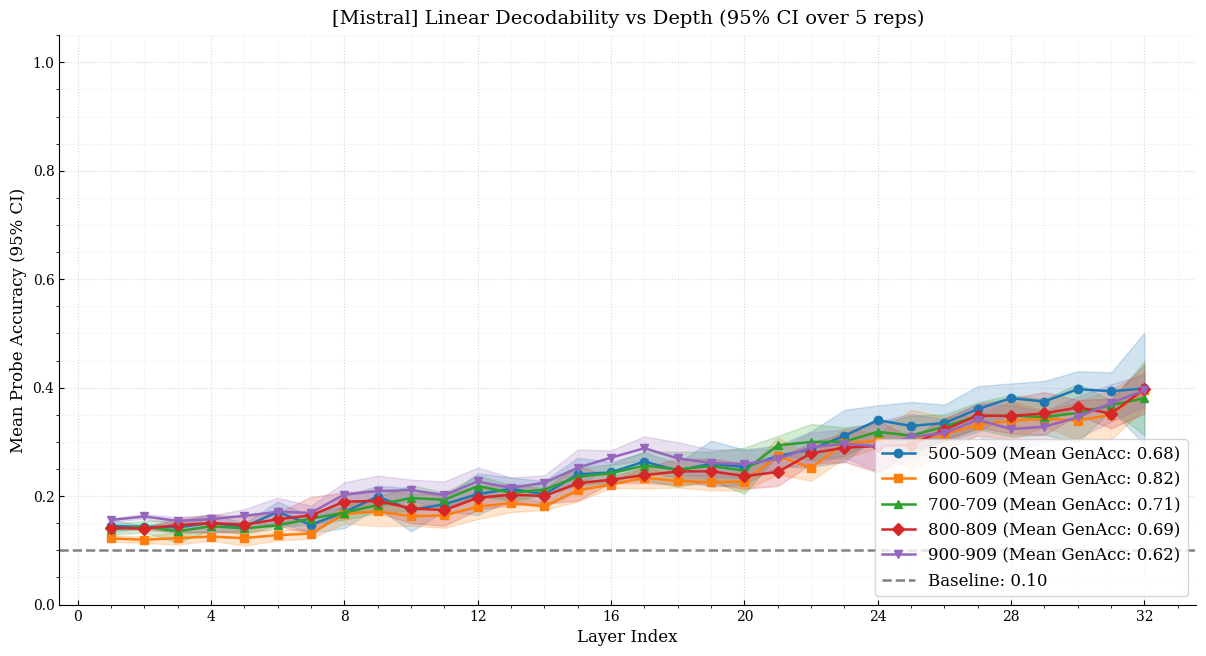

In [6]:
    # ================================
    # --- Plot & save results ---
    # ================================
    plt.rcParams.update({
        'font.size': 10, 'font.family': 'serif', 'axes.labelsize': 12,
        'axes.titlesize': 14, 'xtick.labelsize': 10, 'ytick.labelsize': 10,
        'legend.fontsize': 12, 'lines.linewidth': 1.8, 'lines.markersize': 6,
        'axes.grid': True, 'grid.alpha': 0.5, 'grid.linestyle': ':',
        'savefig.dpi': 600, 'savefig.format': 'pdf', 'savefig.bbox': 'tight',
    })

    try:
        cmap_colors = plt.colormaps['tab10']
    except AttributeError:
        cmap_colors = plt.cm.get_cmap('tab10', len(HP.SUM_RANGES_CONFIG) if HP.SUM_RANGES_CONFIG else 1)

    defined_markers = ['o', 's', '^', 'D', 'v', '*', 'P', 'X', '+', '1']
    color_map = {config["label"]: (cmap_colors(i) if callable(cmap_colors) else cmap_colors.colors[i % len(cmap_colors.colors)])
                 for i, config in enumerate(HP.SUM_RANGES_CONFIG)}
    color_map['chance'] = 'grey'
    marker_map = {config["label"]: defined_markers[i % len(defined_markers)] for i, config in enumerate(HP.SUM_RANGES_CONFIG)}

    fig, ax = plt.subplots(figsize=(12, 6.5))
    plot_title_main = f"[{model_short_name}] Linear Decodability vs Depth (95% CI over {HP.N_REPETITIONS} reps)"
    logger.info(f"Plotting: {plot_title_main}")

    for i, range_label_key in enumerate(final_aggregated_results):
        current_range_overall_data = final_aggregated_results[range_label_key]
        mean_gen_acc, _, _ = calculate_mean_ci(current_range_overall_data["generation_accuracies_reps"])

        plot_layers_values = sorted(current_range_overall_data["probe_accuracies_per_layer_reps"].keys())
        mean_probe_accuracies, lower_bounds, upper_bounds, valid_plot_layers = [], [], [], []

        for layer_val in plot_layers_values:
            accuracies_for_layer_reps = current_range_overall_data["probe_accuracies_per_layer_reps"][layer_val]
            mean_acc, ci_low, ci_up = calculate_mean_ci(accuracies_for_layer_reps)
            if not np.isnan(mean_acc):
                valid_plot_layers.append(layer_val)
                mean_probe_accuracies.append(mean_acc)
                lower_bounds.append(ci_low if not np.isnan(ci_low) else mean_acc)
                upper_bounds.append(ci_up if not np.isnan(ci_up) else mean_acc)

        if valid_plot_layers and mean_probe_accuracies:
            line_color = color_map.get(range_label_key)
            ax.plot(valid_plot_layers, mean_probe_accuracies,
                    marker=marker_map.get(range_label_key, 'x'),
                    label=f"{range_label_key} (Mean GenAcc: {mean_gen_acc:.2f})",
                    color=line_color)
            ax.fill_between(valid_plot_layers, lower_bounds, upper_bounds, color=line_color, alpha=0.2)
        else:
            logger.warning(f"No valid data to plot for range: {range_label_key}")

    constant_n_classes_for_baseline = HP.SUM_RANGES_CONFIG[0]["count"] if HP.SUM_RANGES_CONFIG else 10
    baseline_acc_val = 1.0 / constant_n_classes_for_baseline if constant_n_classes_for_baseline > 0 else 0.0
    ax.axhline(y=baseline_acc_val, linestyle='--', color=color_map['chance'],
               label=f'Baseline: {baseline_acc_val:.2f}', zorder=0)

    ax.set_xlabel("Layer Index")
    ax.set_ylabel("Mean Probe Accuracy (95% CI)")
    ax.set_title(plot_title_main, pad=8)
    if layers_to_probe:
        if len(layers_to_probe) <= 30:
            ax.set_xticks(layers_to_probe)
        else:
            from matplotlib.ticker import MaxNLocator
            ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins='auto'))
    ax.set_ylim(0, 1.05)
    ax.minorticks_on()
    ax.grid(True, linestyle=':', linewidth=0.4, which='minor', alpha=0.4)
    ax.legend(loc='lower right', frameon=True, fontsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(direction='in', top=False, right=False)

    plt.tight_layout(pad=0.5)
    fig_base = f"probe_gen_filtered_repeated_{HP.PROBE_TYPE}_{model_short_name}_{ts}"
    fig_pdf = os.path.join(run_dir, f"{fig_base}.pdf")
    fig_png = os.path.join(run_dir, f"{fig_base}.png")
    plt.savefig(fig_pdf)
    plt.savefig(fig_png, dpi=300)
    logger.info(f"Figure saved: {fig_pdf} & {fig_png}")

    # --- Summary JSON (includes key configs and stats) ---
    # Compute the most frequent best layer (mode) per range
    best_layer_mode = {}
    for range_label_key, data in final_aggregated_results.items():
        bl = [x for x in data["best_layer_indices_reps"] if isinstance(x, int) and x >= 0]
        best_layer_mode[range_label_key] = Counter(bl).most_common(1)[0][0] if bl else -1

    summary = {
        "model": MODEL_NAME,
        "model_short": model_short_name,
        "timestamp": ts,
        "device": str(DEVICE),
        "hyper_params": asdict(HP),
        "probe_type": HP.PROBE_TYPE,
        "probe_epochs": HP.N_PROBE_EPOCHS,
        "probe_lr": HP.PROBE_LR,
        "probe_batch_size": HP.PROBE_BATCH_SIZE,
        "generation_batch_size": HP.GENERATION_BATCH_SIZE,
        "sum_ranges_config": HP.SUM_RANGES_CONFIG,
        "n_samples_per_sum": HP.N_SAMPLES_PER_SUM,
        "test_split_ratio": HP.TEST_SPLIT_RATIO,
        "layers_to_probe": layers_to_probe,
        "logical_num_layers": logical_num_layers,
        "hidden_states_tuple_len": hs_len,
        "results": final_aggregated_results,
        "best_layer_mode_per_range": best_layer_mode
    }
    summary_clean = sanitize_for_json(summary)

    json_path = os.path.join(run_dir, f"summary_{model_short_name}_{ts}.json")
    with open(json_path, "w", encoding="utf-8") as f:
        json.dump(summary_clean, f, ensure_ascii=False, indent=2)
    logger.info(f"Summary JSON saved: {json_path}")

    logger.info(f"Finished model: {MODEL_NAME}")

logger.info("All models finished.")